In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pycreackdb/Segmentation/Ground truth/173.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/248.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/94.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/236.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/340.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/48.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/350.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/314.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/227.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/238.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/61.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/222.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/330.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/278.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/303.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/37.png
/kaggle/input/pycreackdb/Segmentation/Ground truth/231.png
/

In [14]:
# 1. IMPORTS
# =====================================================

import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
                            precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [16]:
# =====================================================
# 2. DATA LOAD  (YOUR CELL 2)
# =====================================================

data_root = "/kaggle/input/pycreackdb/Classification"   # CHANGE IF NECESSARY

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 569 files belonging to 2 classes.
Using 456 files for training.
Found 569 files belonging to 2 classes.
Using 113 files for validation.
Classes: ['With crack', 'Without crack']


In [17]:
# =====================================================
# 3. MAKE TEST SET  (YOUR CELL 3)
# =====================================================

val_images = []
val_labels = []

for x, y in val_ds.unbatch().batch(99999):
    val_images = x.numpy()
    val_labels = y.numpy()
    break

split = int(0.5 * len(val_images))  # 50/50 split for val & test

val_X = val_images[:split]
val_y = val_labels[:split]

test_X = val_images[split:]
test_y = val_labels[split:]

val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_y)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(BATCH_SIZE)

print("VAL:", len(val_X), "TEST:", len(test_X))

VAL: 56 TEST: 57


In [18]:
# =====================================================
# 4. FIXED CBAM ATTENTION MODULE (Keras-compatible)
# =====================================================

from tensorflow.keras import backend as K

def channel_attention(x, ratio=8):
    ch = x.shape[-1]
    
    # Average Pooling branch
    avg = layers.GlobalAveragePooling2D()(x)
    avg = layers.Reshape((1, 1, ch))(avg)
    avg = layers.Conv2D(ch // ratio, kernel_size=1, activation='relu', padding='same')(avg)
    avg = layers.Conv2D(ch, kernel_size=1, activation='sigmoid', padding='same')(avg)
    
    # Max Pooling branch
    mx = layers.GlobalMaxPooling2D()(x)
    mx = layers.Reshape((1, 1, ch))(mx)
    mx = layers.Conv2D(ch // ratio, kernel_size=1, activation='relu', padding='same')(mx)
    mx = layers.Conv2D(ch, kernel_size=1, activation='sigmoid', padding='same')(mx)
    
    # Combine attention
    att = layers.Add()([avg, mx])
    return layers.Multiply()([x, att])


def spatial_attention(x):
    # Use Keras layers instead of raw tf ops
    avg = layers.Lambda(lambda z: K.mean(z, axis=-1, keepdims=True))(x)
    mx = layers.Lambda(lambda z: K.max(z, axis=-1, keepdims=True))(x)
    
    concat = layers.Concatenate(axis=-1)([avg, mx])
    att = layers.Conv2D(1, kernel_size=7, activation='sigmoid', padding='same')(concat)
    
    return layers.Multiply()([x, att])


def cbam_block(x):
    x = channel_attention(x)
    x = spatial_attention(x)
    return x


In [19]:
# =====================================================
# 5. ATTENTION ENHANCED CNN MODEL (fixed)
# =====================================================

def build_attention_cnn(input_shape=(224,224,3), num_classes=3):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling2D()(x)
    x = cbam_block(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = cbam_block(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs=inp, outputs=out)


In [20]:
# =====================================================
# 6. COMPILE + PRINT MODEL SUMMARY
# =====================================================

model = build_attention_cnn(input_shape=(224,224,3), num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n============== Attention CNN Model Summary ==============\n")
model.summary()



============== Attention CNN Model Summary ==============



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ max_pooling2d[0]… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 1, 4)   │        132 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 1, 4)   │        132 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 1, 32)  │        160 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 32)  │        160 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 32)  │          0 │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 112, 112,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 112, 112,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ lambda[0][0],     │
│ (Concatenate)       │ 2)                │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │         99 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 112, 112,  │          0 │ multiply[0][0],   │
│ (Multiply)          │ 32)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │     18,496 │ multiply_1[0][0]

 Total params: 96,480 (376.88 KB)

 Trainable params: 96,480 (376.88 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# =====================================================
# 7. TRAINING
# =====================================================

EPOCHS = 20

train_start = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

train_end = time.time()
print(f"\nTraining Time: {train_end - train_start:.2f} seconds\n")

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6093 - loss: 10.7571 - val_accuracy: 0.3036 - val_loss: 0.9386
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4815 - loss: 0.8479 - val_accuracy: 0.7143 - val_loss: 0.5730
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6880 - loss: 0.6500 - val_accuracy: 0.7143 - val_loss: 0.4594
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7900 - loss: 0.4947 - val_accuracy: 0.8393 - val_loss: 0.4019
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8746 - loss: 0.3614 - val_accuracy: 0.8750 - val_loss: 0.3446
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9000 - loss: 0.2890 - val_accuracy: 0.8750 - val_loss: 0.3221
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8026 - loss: 0.4658 - val_accuracy: 0.8750 - val_loss: 0.3168
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8378 - loss: 0.3705 - val_accuracy: 0.8929 - val_loss

In [22]:
# =====================================================
# 8. EVALUATION ON TEST SET
# =====================================================

eval_start = time.time()

y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

eval_end = time.time()
print(f"Testing Time: {eval_end - eval_start:.2f} seconds\n")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Testing Time: 2.60 seconds



In [23]:
# ---------------- ACCURACY ----------------
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9824561403508771


In [24]:
# ---------------- CLASS ACCURACY ----------------
print("\nClass Accuracy:")
for idx, cls in enumerate(class_names):
    mask = (y_true == idx)
    class_acc = accuracy_score(y_true[mask], y_pred[mask])
    print(f"  {cls}: {class_acc:.4f}")


Class Accuracy:
  With crack: 0.9722
  Without crack: 1.0000


In [25]:
# ---------------- PRECISION / RECALL / F1 ----------------
prec, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro"
)

print("\nPrecision:", prec)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9772727272727273
Recall: 0.9861111111111112
F1 Score: 0.981329839502129


In [26]:
# ---------------- FULL CLASSIFICATION REPORT ----------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

               precision    recall  f1-score   support

   With crack       1.00      0.97      0.99        36
Without crack       0.95      1.00      0.98        21

     accuracy                           0.98        57
    macro avg       0.98      0.99      0.98        57
 weighted avg       0.98      0.98      0.98        57



In [28]:
# ---------------- CONFUSION MATRIX ----------------
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)



Confusion Matrix:
 [[35  1]
 [ 0 21]]


In [30]:
# ---------------- AUC (MULTICLASS OvR) ----------------
y_onehot = tf.keras.utils.to_categorical(y_true, num_classes)
auc = roc_auc_score(y_onehot, y_prob, multi_class="ovr")

print("\nAUC (macro OVR):", auc)


AUC (macro OVR): 0.9947089947089947


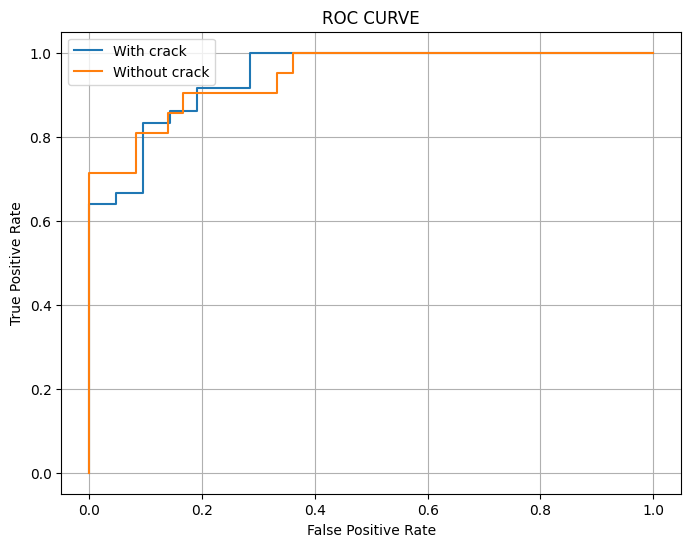

In [153]:
# ---------------- ROC CURVE PLOT ----------------
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_onehot[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=cls)

plt.title("ROC CURVE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()